In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h5>Rough Draft</h5>

Types of models to use :
* Linear Regression (Check if underfit with plots)
    - Log transform skewed distributions
* KNN
* XGBoost
* https://automl.github.io/auto-sklearn/master/

How to finetune model:
* param grid tuning
* Cross Validation
* K Best features
* R-squared, Adjusted R-squared

How to interpret model:
* Feature Importance
* Permutation Importance
* SHAP values and plots
* Partial Dependence Plots (1 and 2D)



GroupKFold (K = 4, Group by country, then remove country)

Pipeline (Scale, PCA)

In [2]:
# df = pd.read_csv('../data/interim/selected_features.csv',index_col=[0])
# poverty_features = pd.read_csv('../data/interim/poverty_features.csv',index_col=[0])

# X = pd.concat([df,poverty_features],axis=1).drop(['Gini index','Country Name'],axis=1).to_numpy()

df = pd.read_csv('../data/interim/radius3_selected_features.csv',index_col=[0])
X = df.drop(['Gini index','Country Name'],axis=1).to_numpy()

y = df['Gini index'].to_numpy()
groups = df['Country Name'].to_numpy()

In [3]:
df.head()

,Year,"Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)","Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)","Inflation, consumer prices (annual %)",GDP (current US$),"Cause of death, by injury (% of total)","Educational attainment, at least Master's or equivalent, population 25+, total (%) (cumulative)","Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)","Population, total","Unemployment, total (% of total labor force) (modeled ILO estimate)",...,"Physicians (per 1,000 people)",Country Name,Gini index,Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population),Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),Poverty gap at $2.15 a day (2017 PPP) (%),Poverty gap at $3.65 a day (2017 PPP) (%),Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Poverty gap at $6.85 a day (2017 PPP) (%),GDP per capita
11420,2002,88.543221,0.00000,0.757421,4.395616e+10,8.507397,16.28310,38.141708,48202470.0,10.140,...,3.0188,Ukraine,29.0,17.0,61.9,0.5,3.7,2.7,20.8,911.906871
11686,2003,88.543221,0.00000,5.179678,5.201035e+10,8.507397,16.28310,38.141708,47812949.0,9.060,...,3.0096,Ukraine,28.7,10.4,54.1,0.2,2.1,1.1,16.0,1087.788007
12624,2007,95.692841,0.03193,10.230103,3.802571e+09,10.150055,15.44759,17.622650,5268400.0,2.677,...,2.3580,Kyrgyz Republic,33.9,33.6,74.2,1.7,9.5,8.8,31.8,721.769526
12687,2007,61.490292,0.25529,4.168633,2.129598e+10,12.359977,2.37209,21.358910,3431614.0,5.844,...,1.3032,Panama,52.7,14.9,30.5,2.2,5.7,6.7,13.6,6205.821576
12879,2008,80.522840,0.79249,4.060305,2.754475e+11,5.055017,9.20796,30.182824,4489544.0,6.770,...,4.0144,Ireland,30.9,0.3,0.8,0.1,0.2,0.2,0.4,61353.106563


<h5>Preprocessing</h5>
Below I set up the initial pipeline that preprocesses the data and splits it into folds.

* since values between countries were imputed, Group K fold seperates the data and makes sure that countries don't overlap.
* Each fold is then standard scaled with the rest of the folds
* In a similar way I use PCA to reduce the 6 poverty into 2

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

preprocess_steps = [('scaler',StandardScaler()),
                    ('ct',ColumnTransformer([('pca',PCA(n_components=2),list(range(14,20)))],remainder='passthrough'))]

In [5]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)

<h5>Linear models</h5>

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.pipeline import Pipeline

ols = Pipeline(steps=preprocess_steps+[('ols',LinearRegression())])
test_scores = cross_val_score(ols,X,y,groups=groups,cv=gkf)

In [44]:
np.average(test_scores)

0.13916719934698693

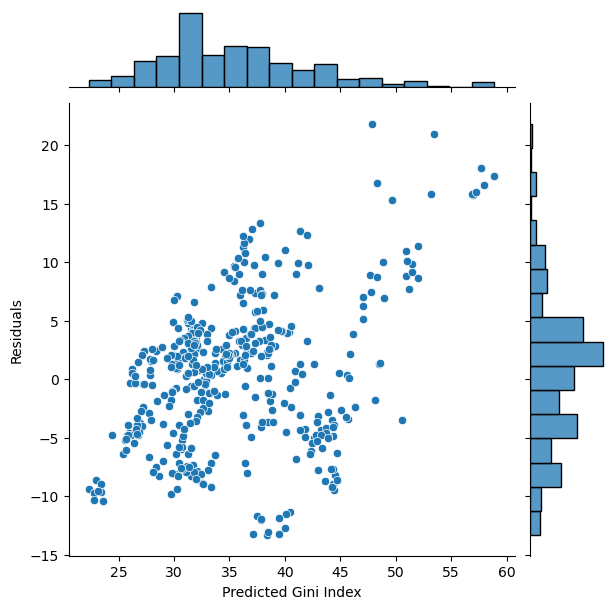

In [46]:
preds = cross_val_predict(ols,X,y,groups=groups,cv=gkf)

sns.jointplot(x=preds,y=preds-y)
plt.xlabel('Predicted Gini Index')
plt.ylabel('Residuals')
plt.show()


Since there's correlation in the residuals and Gini Index isn't normally distributed, Linear regression (or atleast ordinary least squares) isn't a good fit for the data.

* I next tried LassoLars which includes a regularization parameter to prevent overfitting and increases coefficents of features in a forward stepwise manner. 
* Although it doesn't change the fact that the data doesn't fit a linear model, it's coefficients give good insight into which features are most important and the direction of that relationship. 



In [9]:
from sklearn.linear_model import LassoLars

lars = Pipeline(steps=preprocess_steps+[('lars',LassoLars())])

test_scores = cross_val_score(lars,X,y,groups=groups,cv=gkf)

In [10]:
print(np.average(test_scores))

0.24797080509908231


In [11]:
columns = df.drop(['Country Name', 'Gini index'],axis=1).columns.to_list()
feature_names = [col for col in columns if col.find('Poverty') < 0]
feature_names.append('poverty_pca0')
feature_names.append('poverty_pca1')

In [12]:
folds = gkf.split(X,y,groups=groups)
coefs = {}
for f in feature_names:
    coefs[f] = []
for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
    lars.fit(X_train,y_train)
    fold_coefs = lars.named_steps['lars'].coef_
    
    for j in range(len(feature_names)):
        coefs[feature_names[j]].append(fold_coefs[j])

<Axes: >

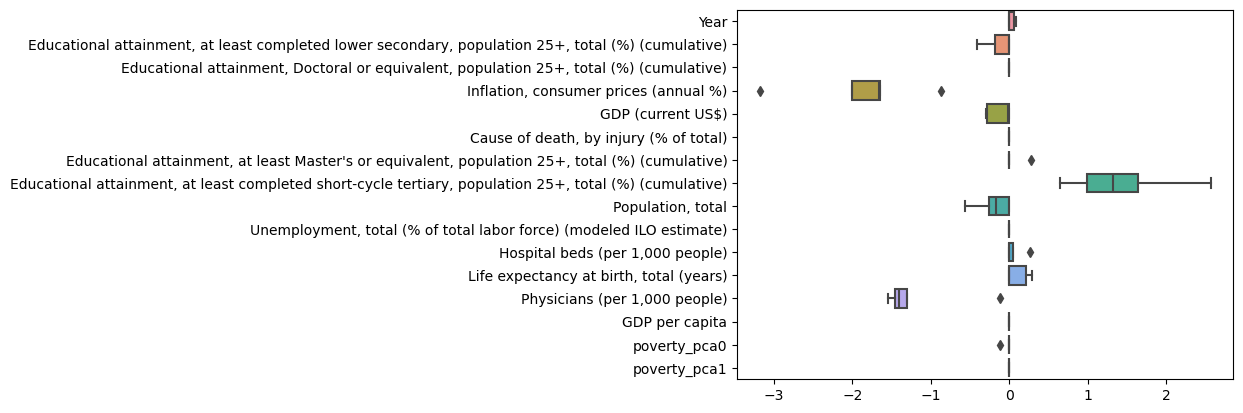

In [13]:
sns.boxplot(pd.DataFrame(coefs),orient='h')

Since all the variables are standard scaled, The coefficients can compared directly.

According to lasso the most important variables in order are:
- Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)  
- Inflation, consumer prices (annual %)
- GDP (current US$)
- Physicians (per 1,000 people)

<h5>K Neighbors Regression</h5>

In [14]:

from sklearn.neighbors import KNeighborsRegressor

KNN = Pipeline(steps=preprocess_steps+[('knn',KNeighborsRegressor())])

test_scores = cross_val_score(KNN,X,y,groups=groups,cv=gkf)

In [15]:
print(test_scores)

[0.19417289 0.5871975  0.8580039  0.15424566 0.65468304]


In [16]:
np.average(test_scores)

0.4896605980486489

In [17]:
from sklearn.model_selection import cross_validate

avg_train_scores = []
avg_test_scores = []
nn_range = range(2,20)

for nn in nn_range:
    train_scores = []
    test_scores = []
    knn = KNN.set_params(knn__n_neighbors=nn)
    scores = cross_validate(knn,X,y,groups=groups,cv=gkf,return_train_score=True)
    
    avg_train_scores.append(np.average(scores['train_score']))
    avg_test_scores.append(np.average(scores['test_score']))

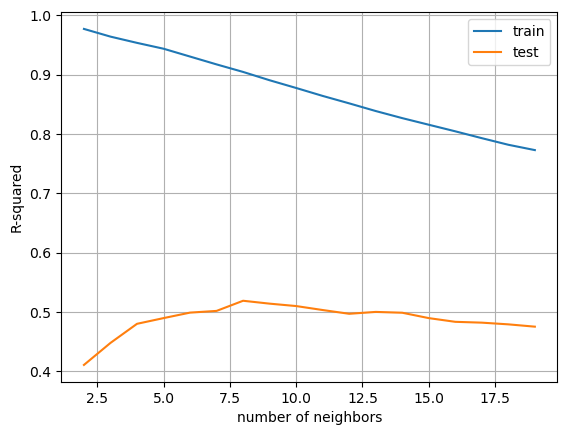

In [18]:
plt.plot(nn_range,avg_train_scores) # type: ignore
plt.plot(nn_range,avg_test_scores) # type: ignore
plt.grid(True)
plt.xlabel('number of neighbors')
plt.ylabel('R-squared')
plt.legend({'train':'blue','test':'orange'})
plt.show()

In [19]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline

avg_train_scores = []
avg_test_scores = []

pipeline = Pipeline(steps=preprocess_steps+[('skb',SelectKBest()),('knn',KNeighborsRegressor())])

for k_val in range(1,16):
    
    model = pipeline.set_params(skb__k=k_val,skb__score_func=mutual_info_regression,knn__n_neighbors=8)

    scores = cross_validate(model,X,y,groups=groups,cv=gkf,return_train_score=True)
    
    avg_train_scores.append(np.average(scores['train_score']))
    avg_test_scores.append(np.average(scores['test_score']))
    

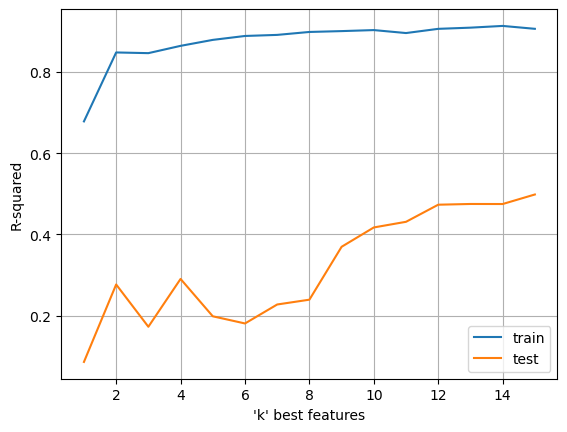

In [20]:
plt.plot(range(1,16),avg_train_scores) # type: ignore
plt.plot(range(1,16),avg_test_scores) # type: ignore
plt.grid(True)
plt.xlabel("'k' best features")
plt.ylabel('R-squared')
plt.legend({'train':'blue','test':'orange'})
plt.show()


The dip in the middle shows that select K best features may not be selecting optimally

Next I run a grid search to tune the parameters for K nearest neighbors

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression,r_regression,mutual_info_regression

pipeline = Pipeline(steps=preprocess_steps+[('skb',SelectKBest()),('knn',KNeighborsRegressor())])

params = {
    'skb__k':range(1,16),                                                 #how many features to select
    'skb__score_func':[mutual_info_regression,f_regression,r_regression], #how to select features
    'knn__n_neighbors':range(5,15),                                       #number of neighbors
    'knn__weights':['uniform','distance'],                                #weigh all neighbors uniformly or by distance
    'knn__p':[1,2,3]                                                      # how to measure distance, manhattan, euclidean, etc.
}

grid_search = GridSearchCV(pipeline,params,cv=gkf)

grid_search.fit(X,y,groups=groups)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pca',
                                                                         PCA(n_components=2),
                                                                         [14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19])])),
                                       ('skb', SelectKBest()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(5, 15), 'knn__p': [1, 2, 3],
                         'knn__weights': ['uniform', 'distance'],
                         'skb__k': range(1, 16),
                         'skb__score_func': [<function mutual_info_regression at 0x13bbe1ee0>,
                                             <function f_regression at 0x13dd700e0>,
                                             <function r_regression at 0x13bbe3f60>]})

In [22]:
grid_search.best_score_

0.6014052910809241

In [23]:
grid_search.best_params_

{'knn__n_neighbors': 12,
 'knn__p': 1,
 'knn__weights': 'uniform',
 'skb__k': 13,
 'skb__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True, force_finite=True)>}

So the best KNN model explains about 60% of the variance and uses 13 of the 16 features

In [24]:
skb = SelectKBest(score_func=f_regression,k=13)

pipe = Pipeline(preprocess_steps)

X_transformed = pipe.fit_transform(X,y)

skb.fit(X_transformed,y)
best_features=skb.get_feature_names_out(feature_names) # type: ignore 

In [25]:
best_features

array(['Year',
       'Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
       'Inflation, consumer prices (annual %)', 'GDP (current US$)',
       'Cause of death, by injury (% of total)',
       'Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)',
       'Population, total',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'Hospital beds (per 1,000 people)',
       'Physicians (per 1,000 people)', 'GDP per capita', 'poverty_pca0',
       'poverty_pca1'], dtype=object)

In [26]:
set(df.columns) - set(best_features)

{'Country Name',
 'Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)',
 "Educational attainment, at least Master's or equivalent, population 25+, total (%) (cumulative)",
 'Gini index',
 'Life expectancy at birth, total (years)',
 'Poverty gap at $2.15 a day (2017 PPP) (%)',
 'Poverty gap at $3.65 a day (2017 PPP) (%)',
 'Poverty gap at $6.85 a day (2017 PPP) (%)',
 'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
 'Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population)',
 'Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population)'}

The three features it omits are Life expectancy, Educational attainment at Doctoral and Educational attainment at Master's

<h5>XG Boost</h5>

In [27]:
from xgboost import XGBRegressor

xgb = Pipeline(preprocess_steps + [('xgb',XGBRegressor())])

test_scores = cross_val_score(xgb,X,y,groups=groups,cv=gkf)

In [28]:
print(test_scores)

[0.50737098 0.51563741 0.78615838 0.20211599 0.6879448 ]


In [29]:
np.average(test_scores)

0.5398455120330016

In [30]:
folds = gkf.split(X,y,groups=groups)
feature_importances = {}
for f in feature_names:
    feature_importances[f] = []

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
    xgb.fit(X_train,y_train)

    fold_fi = xgb.named_steps['xgb'].feature_importances_
    
    for j in range(len(feature_names)):
        feature_importances[feature_names[j]].append(fold_fi[j])
    




In [31]:
pd.DataFrame(feature_importances)

,Year,"Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)","Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)","Inflation, consumer prices (annual %)",GDP (current US$),"Cause of death, by injury (% of total)","Educational attainment, at least Master's or equivalent, population 25+, total (%) (cumulative)","Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)","Population, total","Unemployment, total (% of total labor force) (modeled ILO estimate)","Hospital beds (per 1,000 people)","Life expectancy at birth, total (years)","Physicians (per 1,000 people)",GDP per capita,poverty_pca0,poverty_pca1
0,0.006531,0.022680,0.000822,0.070571,0.014339,0.000818,0.005449,0.632563,0.003968,0.007578,0.019087,0.004327,0.050333,0.007077,0.016333,0.137524
1,0.010155,0.019856,0.001113,0.134248,0.008732,0.002038,0.012376,0.048323,0.003358,0.004577,0.017346,0.004758,0.440468,0.003987,0.003944,0.284725
2,0.006111,0.026095,0.002121,0.569417,0.014088,0.002609,0.012678,0.031365,0.003861,0.026117,0.018472,0.012906,0.051740,0.030045,0.009517,0.182859
3,0.001655,0.032326,0.001226,0.534453,0.018720,0.001257,0.008155,0.179433,0.014814,0.006437,0.010324,0.001607,0.016211,0.005029,0.006666,0.161687
4,0.001336,0.036682,0.001776,0.384441,0.004619,0.000658,0.010626,0.107122,0.004699,0.002974,0.028726,0.004298,0.202683,0.034000,0.005316,0.170044


<Axes: >

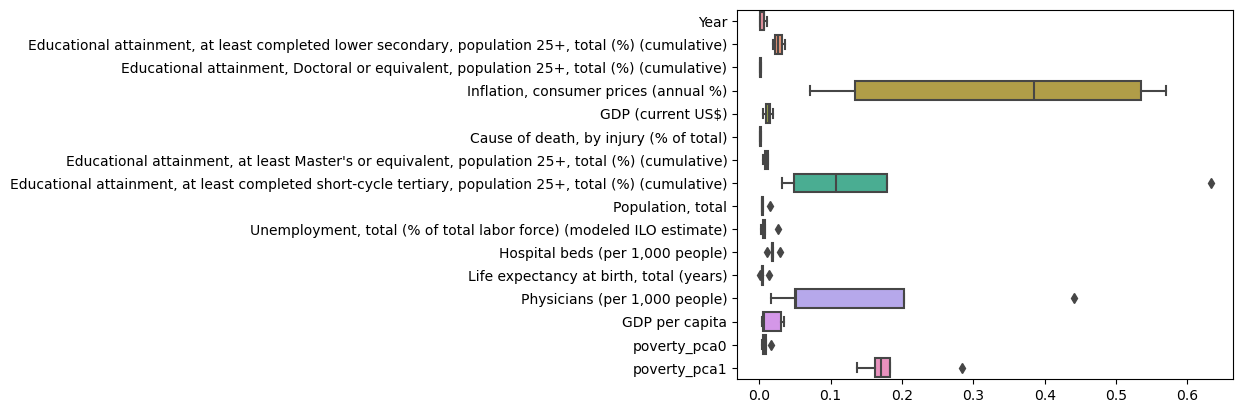

In [32]:
sns.boxplot(pd.DataFrame(feature_importances),orient='h')

- Just like the lassolars model, XGBoost also indicates that Inflation, Physicians per 1000 people and short-cycle tertiary education as the most important features.
- This model also gives significant importance to poverty_pca1 whereas the linear lassolars model gave it a zero coefficient


In [33]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'xgb__n_estimators':np.arange(50,150,5),
    'xgb__max_depth':np.arange(3,9),
    'xgb__learning_rate':np.arange(0,1,0.2),
    'xgb__reg_lambda':np.arange(0,2,0.4),
    'xgb__reg_alpha':np.arange(0,1,0.2)
}

random_search = RandomizedSearchCV(xgb,param_distributions=param_grid,cv=gkf,n_iter=300)

random_search.fit(X,y,groups=groups)

RandomizedSearchCV(cv=GroupKFold(n_splits=5),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pca',
                                                                               PCA(n_components=2),
                                                                               [14,
                                                                                15,
                                                                                16,
                                                                                17,
                                                                                18,
                                                                                19])])),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_s...
                                                           predictor=None,
                                                           random_state=None, ...))]),
                   n_iter=300,
                   param_distributions={'xgb__learning_rate': array([0. , 0.2, 0.4, 0.6, 0.8]),
                                        'xgb__max_depth': array([3, 4, 5, 6, 7, 8]),
                                        'xgb__n_estimators': array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110,
       115, 120, 125, 130, 135, 140, 145]),
                                        'xgb__reg_alpha': array([0. , 0.2, 0.4, 0.6, 0.8]),
                                        'xgb__reg_lambda': array([0. , 0.4, 0.8, 1.2, 1.6])})

In [34]:
random_search.best_score_

0.585394172382494

In [35]:
random_search.best_params_

{'xgb__reg_lambda': 1.6,
 'xgb__reg_alpha': 0.6000000000000001,
 'xgb__n_estimators': 50,
 'xgb__max_depth': 6,
 'xgb__learning_rate': 0.4}

<h5>K Neighbors vs XG Boost</h5>

- Both the KNN and xgboost have similar accuracies
- xgboost model is more interpretable as we can look at the feature importance.
- While KNN is less computationally expensive with training, it is more expensive for prediction since it requires storing the entire dataset 

Let's see if the residuals between both models can highlight any differences between them.

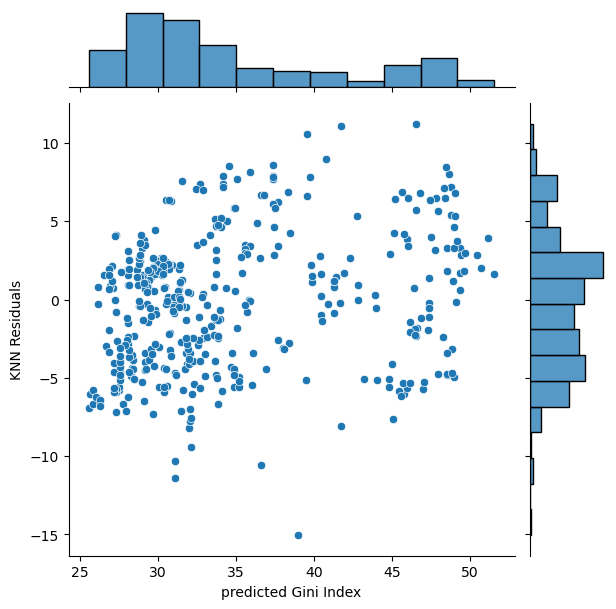

In [40]:
knn_preds = cross_val_predict(grid_search.best_estimator_,X,y,groups=groups,cv=gkf)

sns.jointplot(x=knn_preds,y=knn_preds-y)
plt.xlabel('predicted Gini Index')
plt.ylabel('KNN Residuals')
plt.show()

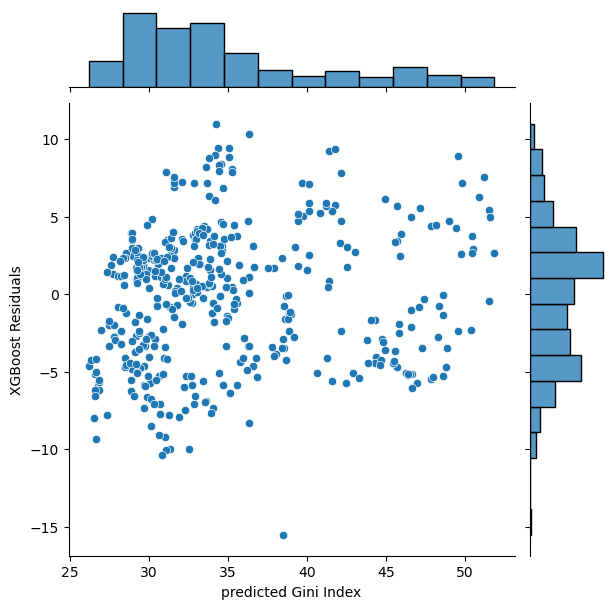

In [42]:
xgb_preds = cross_val_predict(random_search.best_estimator_,X,y,groups=groups,cv=gkf)

sns.jointplot(x=xgb_preds,y=xgb_preds-y)
plt.xlabel('predicted Gini Index')
plt.ylabel('XGBoost Residuals')
plt.show()

Both Models have very similar residual graphs!

another way to decide the best model is to see which model performs better with less features

In [38]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector

xgb_params = random_search.best_params_
xgb_rfe = Pipeline(preprocess_steps + [('rfe',RFE(XGBRegressor())),('xgb',XGBRegressor())])

knn_params = grid_search.best_params_
del knn_params['skb__k']
del knn_params['skb__score_func']
best_knn = KNeighborsRegressor(n_neighbors=12,p=1,weights='uniform')
knn_sfs = Pipeline(preprocess_steps + [('sfs',SequentialFeatureSelector(best_knn)),('knn',KNeighborsRegressor())])

xgb_test_scores = []
knn_test_scores = []

for i in range(1,len(feature_names)):
    knn_model = knn_sfs.set_params(sfs__n_features_to_select=i,**knn_params)
    xgb_model = xgb_rfe.set_params(rfe__n_features_to_select=i,**xgb_params)

    xgb_test_scores.append(np.average(cross_val_score(xgb_model,X,y,groups=groups,cv=gkf)))
    knn_test_scores.append(np.average(cross_val_score(knn_model,X,y,groups=groups,cv=gkf)))


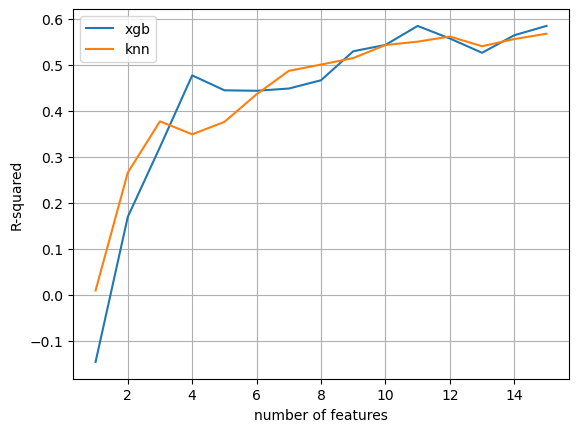

In [39]:
plt.plot(range(1,len(feature_names)),xgb_test_scores) #type: ignore
plt.plot(range(1,len(feature_names)),knn_test_scores) #type: ignore
plt.xlabel('number of features')
plt.ylabel('R-squared')
plt.grid(True)
plt.legend({'xgb':'blue','knn':'orange'})
plt.show()

Both curves are similar but since I plan on looking at the best 4 to 5 features that account for most of the explained variance, I'll use XGBoost